In [20]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import DataFrame, concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [21]:
# Convert series to supervised learning format
def series_to_supervised(data, n_in=5, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = [], []
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Mean Absolute Percentage Error function
def mean_absolute_percentage_error(actual, predicted): 
    actual, predicted = np.array(actual), np.array(predicted)
    return np.mean(np.abs((actual - predicted) / actual)) * 100


In [22]:
# Load dataset
dataset = pd.read_csv('technical_indicators/BHP/TRUH/BHPTRUH.csv',
                      header=0,index_col=0)

values = dataset.values.astype('float32')

# Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# Frame as supervised learning (7 timesteps input, forecasting next 2 timesteps)
reframed = series_to_supervised(scaled, n_in=7, n_out=2)

print(reframed.head())
print(reframed.shape)


    var1(t-7)  var2(t-7)  var3(t-7)  var4(t-7)  var5(t-7)  var6(t-7)  \
7    0.939078   0.433821   0.476306   0.420952   0.268946   0.668519   
8    0.798812   0.486874   0.507167   0.635263   0.054573   0.561213   
9    0.748338   0.638013   0.424270   0.546045   0.055885   0.573335   
10   0.708229   0.570042   0.556674   0.415626   0.058338   0.457615   
11   0.966675   0.528499   0.376159   0.601279   0.058705   0.614055   

    var7(t-7)  var8(t-7)  var9(t-7)  var10(t-7)  ...  var20(t+1)  var21(t+1)  \
7    0.437435   0.455912   0.351408    0.136755  ...    0.020205    0.756791   
8    0.444086   0.498889   0.537026    0.068867  ...    0.023511    0.752719   
9    0.442920   0.488652   0.449023    0.210231  ...    0.025070    0.680661   
10   0.406299   0.492445   0.421689    0.213979  ...    0.032904    0.664997   
11   0.493202   0.475088   0.457066    0.025039  ...    0.031676    0.682739   

    var22(t+1)  var23(t+1)  var24(t+1)  var25(t+1)  var26(t+1)  var27(t+1)  \
7     0.

In [ ]:
values = reframed.values

# Adjust these indices based on your dataset length
train_size = 1079  
train = values[:train_size, :]
test = values[train_size:, :]

# Split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# Reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape)
print(test_X.shape, test_y.shape)


(1079, 1, 260) (1079,)
(244, 1, 260) (244,)


In [24]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='tanh'))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model (you can adjust epochs/batch_size if needed)
history = model.fit(train_X, train_y,
                    epochs=500,
                    batch_size=80,
                    validation_data=(test_X,test_y),
                    verbose=2,
                    shuffle=False)


Epoch 1/500


C:\Users\rithe\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 - 4s - 255ms/step - loss: 0.4184 - val_loss: 0.2055
Epoch 2/500
14/14 - 0s - 10ms/step - loss: 0.2617 - val_loss: 0.0310
Epoch 3/500
14/14 - 0s - 9ms/step - loss: 0.1425 - val_loss: 0.0117
Epoch 4/500
14/14 - 0s - 9ms/step - loss: 0.1002 - val_loss: 0.0131
Epoch 5/500
14/14 - 0s - 10ms/step - loss: 0.0948 - val_loss: 0.0079
Epoch 6/500
14/14 - 0s - 9ms/step - loss: 0.0901 - val_loss: 0.0060
Epoch 7/500
14/14 - 0s - 9ms/step - loss: 0.0881 - val_loss: 0.0051
Epoch 8/500
14/14 - 0s - 10ms/step - loss: 0.0788 - val_loss: 0.0038
Epoch 9/500
14/14 - 0s - 9ms/step - loss: 0.0596 - val_loss: 0.0030
Epoch 10/500
14/14 - 0s - 9ms/step - loss: 0.0354 - val_loss: 0.0032
Epoch 11/500
14/14 - 0s - 10ms/step - loss: 0.0218 - val_loss: 0.0082
Epoch 12/500
14/14 - 0s - 9ms/step - loss: 0.0173 - val_loss: 0.0057
Epoch 13/500
14/14 - 0s - 9ms/step - loss: 0.0141 - val_loss: 0.0034
Epoch 14/500
14/14 - 0s - 9ms/step - loss: 0.0143 - val_loss: 0.0025
Epoch 15/500
14/14 - 0s - 11ms/step - loss: 0.013

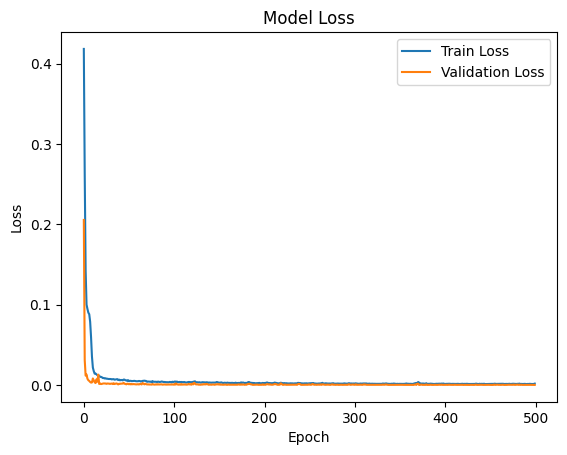

In [25]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [26]:
# Make predictions on test set
yhat = model.predict(test_X)

# Reshape test data to original shape for inverse scaling
test_X_reshaped = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# Invert scaling for forecasted values
inv_yhat = np.concatenate((yhat, test_X_reshaped[:, -28:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# Invert scaling for actual values
test_y_reshaped = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y_reshaped, test_X_reshaped[:, -28:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# Calculate performance metrics on original scale data
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
mse=mean_squared_error(inv_y, inv_yhat)
r2 = r2_score(inv_y, inv_yhat)
mae = mean_absolute_error(inv_y, inv_yhat)
mape = mean_absolute_percentage_error(inv_y, inv_yhat)

print(f'Test RMSE: {rmse:.3f}')
print(f'R2 Score: {r2:.3f}')
print(f'MAE: {mae:.3f}')


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
Test RMSE: 0.002
R2 Score: 0.972
MAE: 0.002


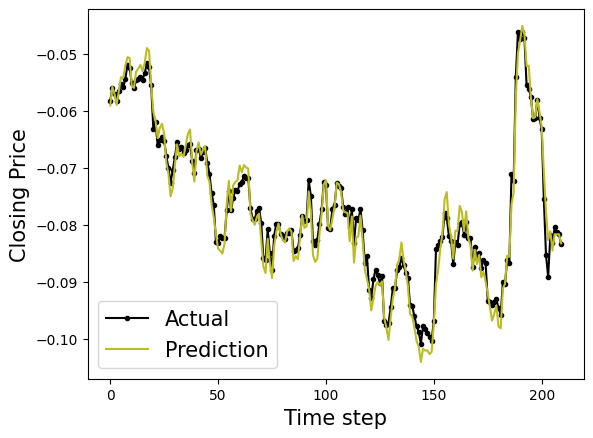

In [27]:
aa=[x for x in range(210)]
plt.plot(aa, inv_y[:210], marker='.', color='black', label="Actual")
plt.plot(aa, inv_yhat[:210], 'tab:olive', label="Prediction")
plt.ylabel('Closing Price', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()


Model input shape: (None, 1, 260)
Model expects 260 features
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


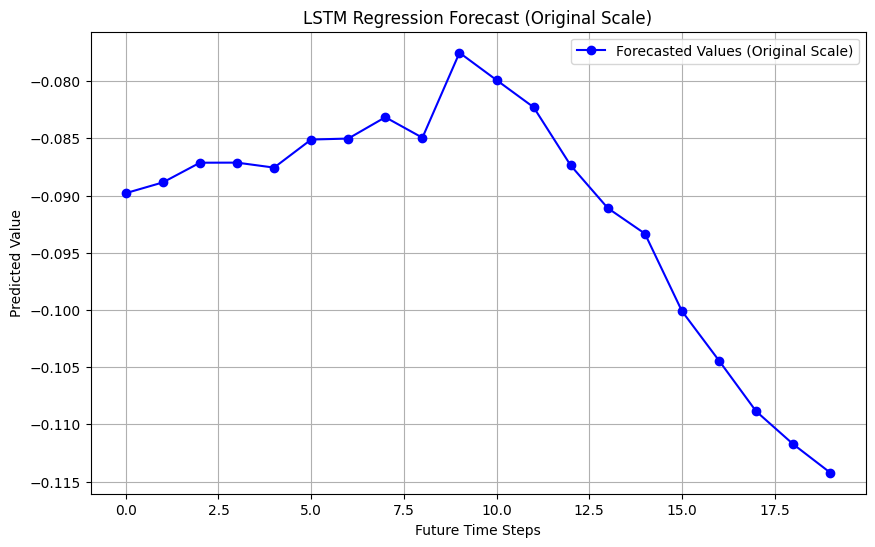

In [30]:
n_future = 20

# Check model input shape
print("Model input shape:", model.input_shape)

# Get expected feature count
expected_features = model.input_shape[-1]
print(f"Model expects {expected_features} features")

# Prepare forecast input
forecast_input = reframed.values[-n_future:, :-1]  # Select last `n_future` rows, exclude target column
forecast_input = forecast_input.reshape((forecast_input.shape[0], 1, forecast_input.shape[1]))

# Make predictions
forecast = model.predict(forecast_input)

# Prepare a dummy array for inverse transformation
n_features = scaled.shape[1]  # Use the number of features originally scaled
dummy = np.zeros((forecast.shape[0], n_features))

# Insert forecasted values in the first column
dummy[:, 0] = forecast.flatten()  # Place predictions in the first column

# Fill the rest with corresponding last known values from `scaled`
dummy[:, 1:] = scaled[-n_future:, 1:]  # Use only the features present in `scaled`

# Perform inverse scaling
inv_forecast = scaler.inverse_transform(dummy)[:, 0]  # Extract only first column

# Plot the forecasted values in the **original scale**
plt.figure(figsize=(10, 6))
plt.plot(range(n_future), inv_forecast, 'b-o', label='Forecasted Values (Original Scale)')
plt.title('LSTM Regression Forecast (Original Scale)')
plt.xlabel('Future Time Steps')
plt.ylabel('Predicted Value')
plt.legend()
plt.grid(True)
plt.show()
